Dataset loaded: 84 rows, 9 columns
Files: 3
Missing rates: [np.int64(10), np.int64(20), np.int64(30), np.int64(40)]
Methods: 7

ANALYSIS BY MISSING RATE

NRMSE Summary by Missing Rate and Method:
                                          mean     std     min     max  count
rate method                                                                  
10   Hankel+SVD+KNN                     0.0781  0.0095  0.0724  0.0891      3
     ewma (alpha=0.2)                   0.1072  0.0444  0.0729  0.1574      3
     hankel+knn+svd (L=72, k=5, λ=0.2)  0.0681  0.0161  0.0497  0.0796      3
     kalman arima (1,1,1)               0.0777  0.0159  0.0595  0.0884      3
     kalman structural (level)          0.0891  0.0282  0.0602  0.1166      3
     knn imputer (k=5)                  0.1429  0.0580  0.1022  0.2093      3
     linear interpolation               0.0566  0.0185  0.0394  0.0762      3
20   Hankel+SVD+KNN                     0.0724  0.0074  0.0639  0.0771      3
     ewma (alpha=0.2)   

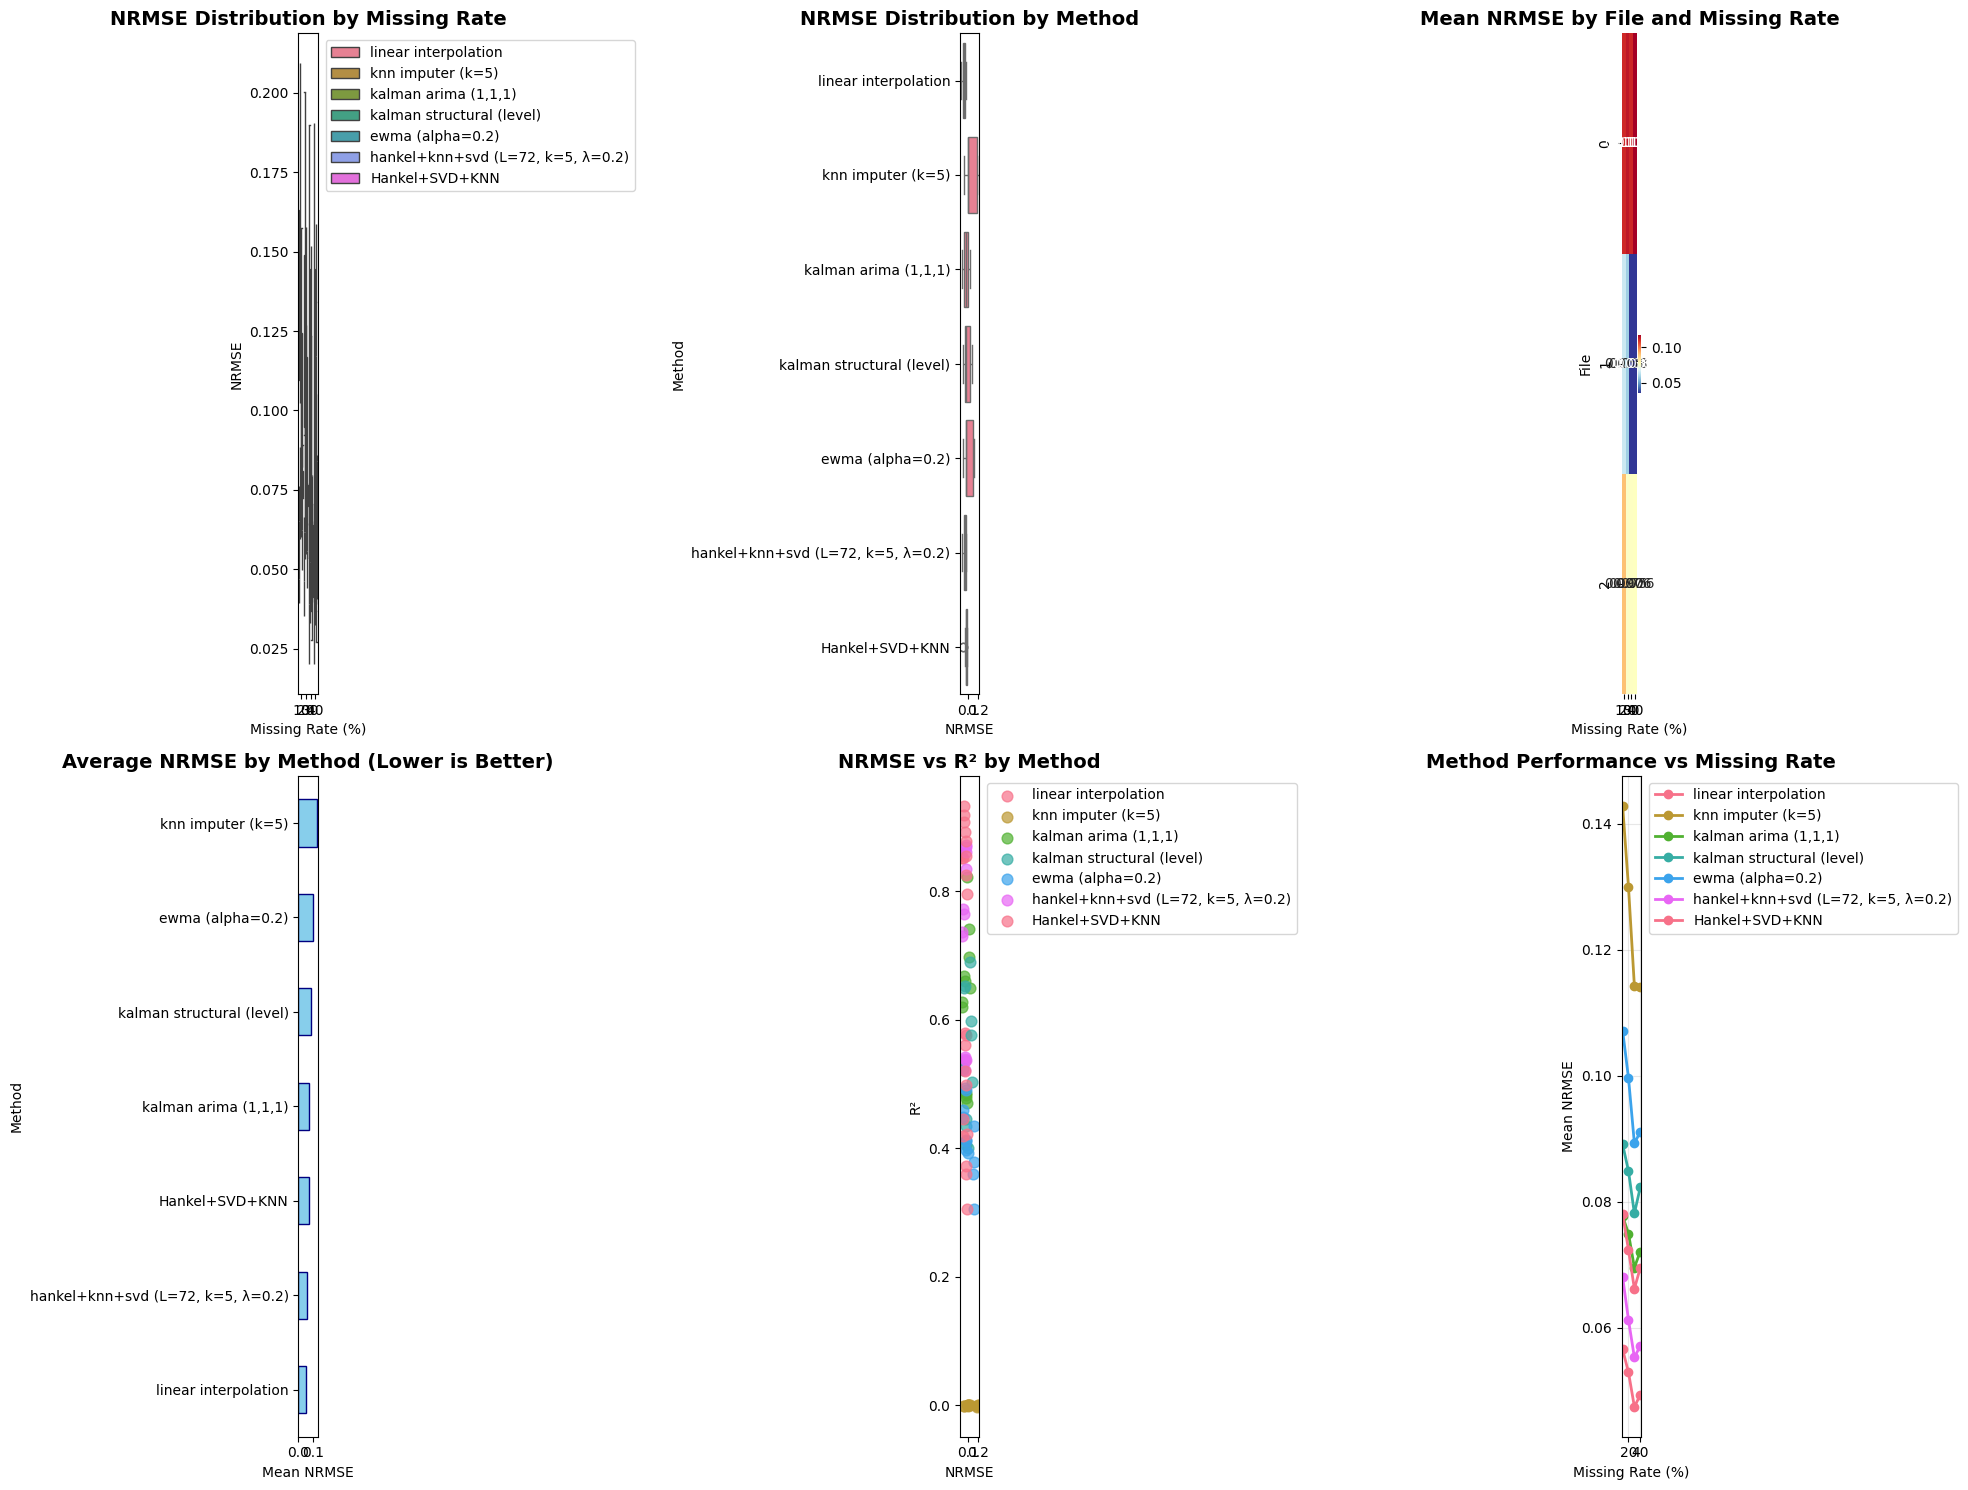

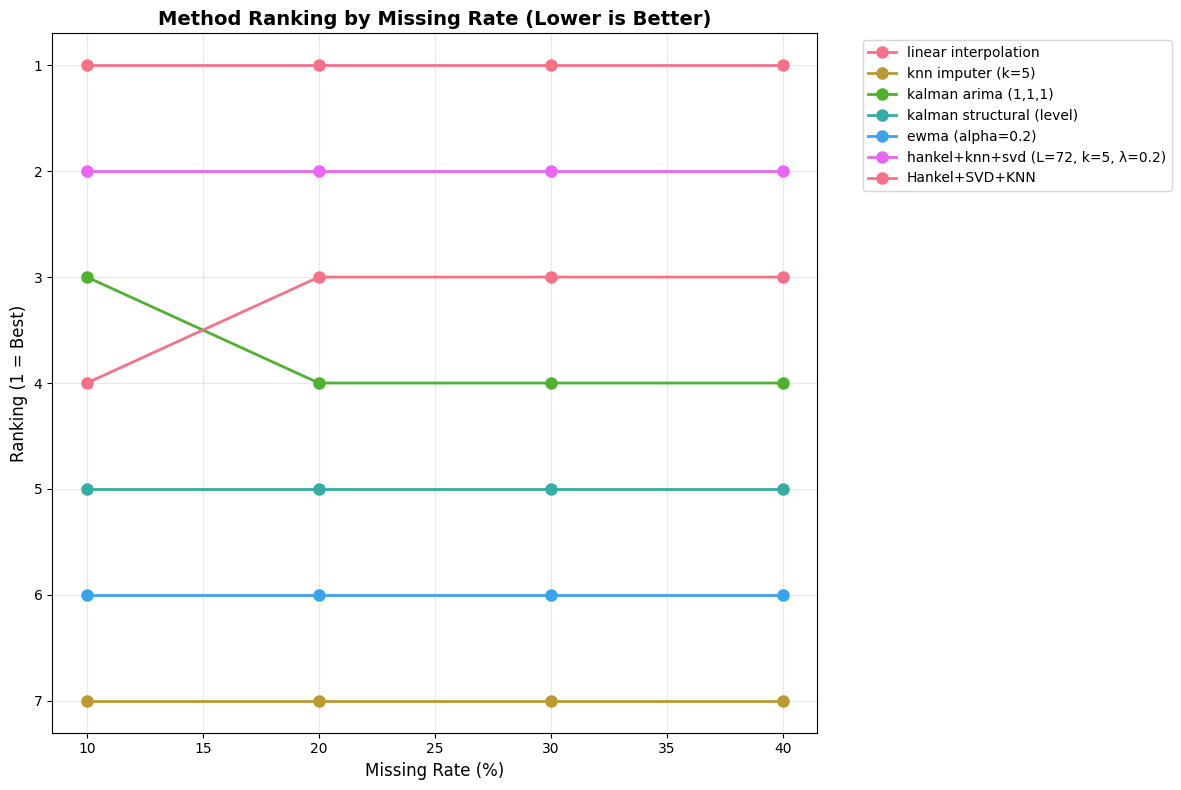


COMPREHENSIVE IMPUTATION METHODS COMPARISON REPORT

Dataset Overview:
- Total observations: 84
- Number of files: 3
- Missing rates tested: 10, 20, 30, 40%
- Number of methods: 7
- Methods tested: linear interpolation, knn imputer (k=5), kalman arima (1,1,1), kalman structural (level), ewma (alpha=0.2), hankel+knn+svd (L=72, k=5, λ=0.2), Hankel+SVD+KNN

Best Overall Method: linear interpolation (Mean NRMSE: 0.0516)
Most Consistent Method: Hankel+SVD+KNN (NRMSE Std: 0.0160)

Performance Trends:
- linear interpolation: NRMSE decreases with missing rate (correlation: -0.173)
- knn imputer (k=5): NRMSE decreases with missing rate (correlation: -0.210)
- kalman arima (1,1,1): NRMSE stable with missing rate (correlation: -0.099)
- kalman structural (level): NRMSE stable with missing rate (correlation: -0.092)
- ewma (alpha=0.2): NRMSE decreases with missing rate (correlation: -0.147)
- hankel+knn+svd (L=72, k=5, λ=0.2): NRMSE decreases with missing rate (correlation: -0.244)
- Hankel+SVD+KN

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

def load_and_prepare_data(csv_file):
    """
    Load and prepare the imputation results data
    """
    df = pd.read_csv(csv_file)
    
    # Clean column names (remove any extra spaces)
    df.columns = df.columns.str.strip()
    
    # Clean method names for better visualization
    df['method'] = df['method'].str.strip()
    
    print(f"Dataset loaded: {len(df)} rows, {len(df.columns)} columns")
    print(f"Files: {df['file'].nunique()}")
    print(f"Missing rates: {sorted(df['rate'].unique())}")
    print(f"Methods: {df['method'].nunique()}")
    
    return df

def analyze_by_missing_rate(df):
    """
    Compare methods by missing rate
    """
    print("\n" + "="*60)
    print("ANALYSIS BY MISSING RATE")
    print("="*60)
    
    # Summary statistics by rate and method
    rate_summary = df.groupby(['rate', 'method']).agg({
        'nrmse': ['mean', 'std', 'min', 'max', 'count'],
        'rmse': ['mean', 'std'],
        'mae': ['mean', 'std'],
        'r2': ['mean', 'std']
    }).round(4)
    
    print("\nNRMSE Summary by Missing Rate and Method:")
    print(rate_summary['nrmse'])
    
    # Best method for each missing rate
    print("\nBest Method by Missing Rate (lowest mean NRMSE):")
    best_by_rate = df.groupby(['rate', 'method'])['nrmse'].mean().reset_index()
    best_methods = best_by_rate.loc[best_by_rate.groupby('rate')['nrmse'].idxmin()]
    for _, row in best_methods.iterrows():
        print(f"Rate {row['rate']}%: {row['method']} (NRMSE: {row['nrmse']:.4f})")
    
    return rate_summary, best_methods

def analyze_by_file(df):
    """
    Compare methods by file
    """
    print("\n" + "="*60)
    print("ANALYSIS BY FILE")
    print("="*60)
    
    # Summary statistics by file and method
    file_summary = df.groupby(['file', 'method']).agg({
        'nrmse': ['mean', 'std', 'min', 'max', 'count'],
        'rmse': ['mean', 'std'],
        'mae': ['mean', 'std'],
        'r2': ['mean', 'std']
    }).round(4)
    
    print("\nNRMSE Summary by File and Method:")
    print(file_summary['nrmse'])
    
    # Best method for each file
    print("\nBest Method by File (lowest mean NRMSE):")
    best_by_file = df.groupby(['file', 'method'])['nrmse'].mean().reset_index()
    best_methods_file = best_by_file.loc[best_by_file.groupby('file')['nrmse'].idxmin()]
    for _, row in best_methods_file.iterrows():
        print(f"File {row['file']}: {row['method']} (NRMSE: {row['nrmse']:.4f})")
    
    return file_summary, best_methods_file

def statistical_tests(df):
    """
    Perform statistical significance tests
    """
    print("\n" + "="*60)
    print("STATISTICAL SIGNIFICANCE TESTS")
    print("="*60)
    
    # Friedman test for overall method comparison
    methods = df['method'].unique()
    method_groups = [df[df['method'] == method]['nrmse'].values for method in methods]
    
    try:
        friedman_stat, friedman_p = stats.friedmanchisquare(*method_groups)
        print(f"\nFriedman Test (overall method comparison):")
        print(f"Statistic: {friedman_stat:.4f}, p-value: {friedman_p:.4f}")
        
        if friedman_p < 0.05:
            print("Result: Significant differences between methods (p < 0.05)")
        else:
            print("Result: No significant differences between methods (p >= 0.05)")
    except:
        print("Could not perform Friedman test (insufficient data or other issue)")
    
    # Pairwise comparisons for each missing rate
    print("\nPairwise Method Comparisons by Missing Rate:")
    for rate in sorted(df['rate'].unique()):
        rate_data = df[df['rate'] == rate]
        print(f"\nMissing Rate: {rate}%")
        
        methods_rate = rate_data['method'].unique()
        if len(methods_rate) >= 2:
            for i, method1 in enumerate(methods_rate):
                for method2 in methods_rate[i+1:]:
                    data1 = rate_data[rate_data['method'] == method1]['nrmse']
                    data2 = rate_data[rate_data['method'] == method2]['nrmse']
                    
                    if len(data1) > 1 and len(data2) > 1:
                        stat, p_val = stats.mannwhitneyu(data1, data2, alternative='two-sided')
                        significance = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "ns"
                        print(f"  {method1[:20]:<20} vs {method2[:20]:<20}: p={p_val:.4f} {significance}")

def create_visualizations(df):
    """
    Create comprehensive visualizations
    """
    print("\n" + "="*60)
    print("CREATING VISUALIZATIONS")
    print("="*60)
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. NRMSE by Missing Rate (Box Plot)
    plt.subplot(2, 3, 1)
    sns.boxplot(data=df, x='rate', y='nrmse', hue='method')
    plt.title('NRMSE Distribution by Missing Rate', fontsize=14, fontweight='bold')
    plt.xlabel('Missing Rate (%)')
    plt.ylabel('NRMSE')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xticks(rotation=0)
    
    # 2. NRMSE by Method (Box Plot)
    plt.subplot(2, 3, 2)
    sns.boxplot(data=df, y='method', x='nrmse')
    plt.title('NRMSE Distribution by Method', fontsize=14, fontweight='bold')
    plt.xlabel('NRMSE')
    plt.ylabel('Method')
    
    # 3. NRMSE by File and Rate (Heatmap)
    plt.subplot(2, 3, 3)
    pivot_data = df.groupby(['file', 'rate'])['nrmse'].mean().reset_index()
    pivot_table = pivot_data.pivot(index='file', columns='rate', values='nrmse')
    sns.heatmap(pivot_table, annot=True, fmt='.3f', cmap='RdYlBu_r')
    plt.title('Mean NRMSE by File and Missing Rate', fontsize=14, fontweight='bold')
    plt.xlabel('Missing Rate (%)')
    plt.ylabel('File')
    
    # 4. Method Performance Ranking
    plt.subplot(2, 3, 4)
    method_means = df.groupby('method')['nrmse'].mean().sort_values()
    method_means.plot(kind='barh', color='skyblue', edgecolor='navy')
    plt.title('Average NRMSE by Method (Lower is Better)', fontsize=14, fontweight='bold')
    plt.xlabel('Mean NRMSE')
    plt.ylabel('Method')
    
    # 5. NRMSE vs R² Scatter Plot
    plt.subplot(2, 3, 5)
    for method in df['method'].unique():
        method_data = df[df['method'] == method]
        plt.scatter(method_data['nrmse'], method_data['r2'], 
                   label=method, alpha=0.7, s=60)
    plt.xlabel('NRMSE')
    plt.ylabel('R²')
    plt.title('NRMSE vs R² by Method', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # 6. Method Performance by Missing Rate (Line Plot)
    plt.subplot(2, 3, 6)
    rate_method_means = df.groupby(['rate', 'method'])['nrmse'].mean().reset_index()
    for method in df['method'].unique():
        method_data = rate_method_means[rate_method_means['method'] == method]
        plt.plot(method_data['rate'], method_data['nrmse'], 
                marker='o', label=method, linewidth=2, markersize=6)
    plt.xlabel('Missing Rate (%)')
    plt.ylabel('Mean NRMSE')
    plt.title('Method Performance vs Missing Rate', fontsize=14, fontweight='bold')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional detailed plot for method ranking by rate
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Create ranking plot
    rates = sorted(df['rate'].unique())
    methods = df['method'].unique()
    
    rankings = {}
    for rate in rates:
        rate_data = df[df['rate'] == rate]
        method_means = rate_data.groupby('method')['nrmse'].mean().sort_values()
        rankings[rate] = {method: rank for rank, method in enumerate(method_means.index, 1)}
    
    # Plot ranking changes
    for method in methods:
        method_rankings = [rankings[rate].get(method, len(methods)) for rate in rates]
        ax.plot(rates, method_rankings, marker='o', label=method, linewidth=2, markersize=8)
    
    ax.set_xlabel('Missing Rate (%)', fontsize=12)
    ax.set_ylabel('Ranking (1 = Best)', fontsize=12)
    ax.set_title('Method Ranking by Missing Rate (Lower is Better)', fontsize=14, fontweight='bold')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    ax.invert_yaxis()  # Invert y-axis so rank 1 is at the top
    ax.set_yticks(range(1, len(methods) + 1))
    
    plt.tight_layout()
    plt.show()

def generate_report(df):
    """
    Generate a comprehensive text report
    """
    print("\n" + "="*80)
    print("COMPREHENSIVE IMPUTATION METHODS COMPARISON REPORT")
    print("="*80)
    
    # Overall statistics
    print(f"\nDataset Overview:")
    print(f"- Total observations: {len(df)}")
    print(f"- Number of files: {df['file'].nunique()}")
    print(f"- Missing rates tested: {', '.join(map(str, sorted(df['rate'].unique())))}%")
    print(f"- Number of methods: {df['method'].nunique()}")
    print(f"- Methods tested: {', '.join(df['method'].unique())}")
    
    # Best overall method
    overall_best = df.groupby('method')['nrmse'].mean().idxmin()
    overall_best_score = df.groupby('method')['nrmse'].mean().min()
    print(f"\nBest Overall Method: {overall_best} (Mean NRMSE: {overall_best_score:.4f})")
    
    # Method consistency analysis
    method_std = df.groupby('method')['nrmse'].std().sort_values()
    most_consistent = method_std.idxmin()
    print(f"Most Consistent Method: {most_consistent} (NRMSE Std: {method_std.min():.4f})")
    
    # Performance by missing rate trend
    print(f"\nPerformance Trends:")
    for method in df['method'].unique():
        method_data = df[df['method'] == method]
        rate_correlation = method_data[['rate', 'nrmse']].corr().iloc[0,1]
        trend = "increases" if rate_correlation > 0.1 else "decreases" if rate_correlation < -0.1 else "stable"
        print(f"- {method}: NRMSE {trend} with missing rate (correlation: {rate_correlation:.3f})")

def main():
    """
    Main execution function
    """
 
    
    try:
        df = load_and_prepare_data("./results.csv")
        
        # Perform analyses
        rate_summary, best_by_rate = analyze_by_missing_rate(df)
        file_summary, best_by_file = analyze_by_file(df)
        
        # Statistical tests
        statistical_tests(df)
        
        # Create visualizations
        create_visualizations(df)
        
        # Generate comprehensive report
        generate_report(df)
        
        # Save results to files
        save_results = input("\nSave detailed results to files? (y/n): ").strip().lower()
        if save_results == 'y':
            # Save summaries
            rate_summary.to_csv('nrmse_analysis_by_rate.csv')
            file_summary.to_csv('nrmse_analysis_by_file.csv')
            
            # Save best methods
            best_by_rate.to_csv('best_methods_by_rate.csv', index=False)
            best_by_file.to_csv('best_methods_by_file.csv', index=False)
            
            print("Results saved to CSV files!")
            
    except FileNotFoundError:
        print(f"Error: Could not find the file '{csv_file}'. Please check the path.")
    except Exception as e:
        print(f"Error: {str(e)}")
        print("Please check your CSV file format and try again.")

if __name__ == "__main__":
    main()